# Neural Network for Predicting Pedestrians Velocity

This notebook is the pipeline we used to preprocess dataset, train neural network and collect useful training results. Multiple settings of the neural network use the same pipeline here. 

In [45]:
# import all the required packages
import os
import datetime
import tensorboard
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import pytorch_lightning as pl

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Run this line if the notebook crashed when plotting something

In [46]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 1. Data Preparation

#### Path

In [47]:
root = os.getcwd()
vadere_dataset_path = os.path.join(root, "dataset", "vadere_generated")

#### Device

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using the device",device)

Using the device cuda:0


### Data Preprocessing: Set contain_sk=True if training the network with the info of sk (NN1); contain_sk=False without sk(NN2)
Check codes: utils\vadereOutputLoader.py

#### The following codes load a trial dataset.

In [49]:
from utils.vadereOutputLoader import vadereOutputLoader

nameOfDataset = "trial_data.txt"
numOfNeighbours = 3
contain_sk = True
numOfCols = 4 + 2*numOfNeighbours - (not contain_sk)

rawdataLoader = vadereOutputLoader(vadere_dataset_path, vadere_dataset_path)
rawdata, sk = rawdataLoader.loadData(nameOfDataset, numOfNeighbours, need_processing=True, contain_sk=contain_sk, return_sk=True)

#### The following codes load the bottlenect datasets.

In [50]:
from utils.vadereOutputLoader import vadereOutputLoader

dataset_name_list = ["bottleneck_070.txt", "bottleneck_095.txt",
                     "bottleneck_120.txt", "bottleneck_180.txt"]
numOfNeighbours = 10
contain_sk = True
numOfCols = 4 + 2*numOfNeighbours - (not contain_sk)

rawdataLoader = vadereOutputLoader(
    vadere_dataset_path, vadere_dataset_path)
rawdata, sk = rawdataLoader.mergeDataset(
    dataset_name_list, "merged_bottleneck.txt", numOfNeighbours, need_processing=True, contain_sk=contain_sk, return_sk=True)


#### Normalize the Relative positions:

In [ ]:
from sklearn.preprocessing import normalize
rawdata[-2*numOfNeighbours:] = normalize(rawdata[-2*numOfNeighbours:], axis=0, norm="l2")

#### Customized Dataset class and Dataloaders: 
Check codes: utils\crowdDataset.py

In [53]:
from utils.crowdDataset import crowdDataset

total = len(rawdata)
np.random.seed(118010142)
randidx = np.arange(total)
np.random.shuffle(randidx)

train_idx = np.arange(int(total*.6))
val_idx = np.arange(int(total*.6), int(total*.8))
test_idx = np.arange(int(total*.8), total)


train = crowdDataset(rawdata[train_idx], device)
val = crowdDataset(rawdata[val_idx], device)
test = crowdDataset(rawdata[test_idx], device)

batch_size = 16
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)


## 2. Training Neural Network

In [54]:
%tensorboard --logdir lightning_logs

UsageError: Line magic function `%tensorboard` not found.


#### Define the network
A simple example network is shown here. Modify the following block to construct different network structure.

In [55]:
from utils.network import FullyConnectedNet

hparams = {
    "numOfLayers": 1,
    "layerSize": [3],
    "learning_rate": 0.0001
}

model = FullyConnectedNet(hparams=hparams, input_size=rawdata.shape[1]-1, output_size=1)

In [56]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

# default logger used by trainer
logger = TensorBoardLogger(
    save_dir=os.getcwd(),
    version=model.version,
    name='lightning_logs'
)

early_stop_callback = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    verbose = False,
    mode = "max"
)

trainer = pl.Trainer(
    max_epochs=50,
    progress_bar_refresh_rate=25,
    gpus=1,
    callbacks=[early_stop_callback],
    logger = logger
)
trainer.fit(model, train_dataloader=trainloader, val_dataloaders=valloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | model     | ModuleList | 70    
-----------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Epoch 0:   3%|▎         | 25/892 [00:00<00:03, 269.53it/s, loss=1.02, v_num=1918]

C:\Users\Linnore\anaconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\data_loading.py:103: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'
C:\Users\Linnore\anaconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\data_loading.py:103: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'


Epoch 5: 100%|██████████| 892/892 [00:02<00:00, 345.58it/s, loss=0.121, v_num=1918]


In [57]:
trainer.log_dir

'd:\\GitHub\\MLCMS-Final-Project\\lightning_logs\\1_3_20210713-211918'

In [58]:
trainer.logged_metrics

{'epoch': tensor(5.),
 'val_loss': tensor(0.1119),
 'train_loss': tensor(0.0830, device='cuda:0')}

#### Output summary of the trained model: 

d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_summary.txt exists, model summary will be attached to the end of this file.


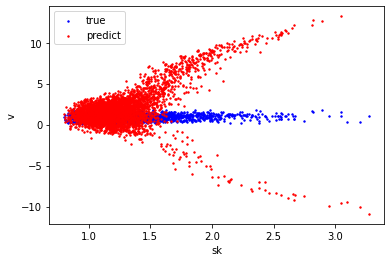

Plot saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\plots\1_3_20210713-211918.png
Model prediction saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_prediction\1_3_20210713-211918_prediction.txt


In [59]:
if contain_sk:
    summary_folder_path = os.path.join(root, "NN1_model_summary")
else:
    summary_folder_path = os.path.join(root, "NN2_model_summary")

vhat = model(torch.tensor(rawdata[test_idx, 1:], dtype=torch.float32)).detach().numpy().reshape(-1)
v = torch.tensor(rawdata[test_idx, 0], dtype=torch.float32).detach().numpy()

model.output_summary(v, vhat, sk[test_idx], trainer.logged_metrics, "B", "B", summary_folder_path)